# Header

In [4]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from lerepi.core.parser import lerepi_parser
from lerepi.core import handler
import abc
import os
import lerepi
import healpy as hp

from lenscarf.utils import read_map
from plancklens.qcinv import opfilt_pp

MSC: using scarf with 2 OMP threads
could not setup healpix hack. reverting to standard healpy


In [5]:
import importlib.util as iu
import numpy as np
import healpy as hp
import os, sys
from os.path import join as opj
import healpy as hp
import matplotlib
import plancklens
from plancklens import utils, n0s
matplotlib.rcParams.update({'font.size': 18})

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.gridspec as gridspec


from astropy.io import fits
from lenscarf.iterators.statics import rec
import plancklens
from plancklens import utils, qresp
from plancklens.sims import planck2018_sims

from component_separation.MSC.MSC import pospace as ps
from lenscarf.utils import cli

import component_separation.transformer as trsf
from component_separation.cs_util import Config


import hashlib

MSC: reverting to standard healpy


In [7]:
csu = Config('Planck')
colors = csu.CB_color_cycle
colors_lt = csu.CB_color_cycle_lighter

nside = 2048
lmax_cl = 2048
lmax_plot = 195
lmax_qlm = 2500
lmax_mask = 4096

simids = np.arange(0,30)

bk14_edges = np.array([2,55,90,125,160,195,230,265,300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]) # BK14 is [ 55  90 125 160 195 230 265 300], from bk14 = h5py.File('/global/homes/s/sebibel/notebooks/CMBS4/datasharing/likedata_BK14.mat', 'r')['likedata']['lval'][0,:]
ioreco_edges = np.array([2,30,200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])

iteration = [0,12]

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

In [8]:
def clamp(val, minimum=0, maximum=255):
    if val < minimum:
        return minimum
    if val > maximum:
        return maximum
    return val

def colorscale(hexstr, scalefactor):
    """
    Scales a hex string by ``scalefactor``. Returns scaled hex string.

    To darken the color, use a float value between 0 and 1.
    To brighten the color, use a float value greater than 1.

    >>> colorscale("#DF3C3C", .5)
    #6F1E1E
    >>> colorscale("#52D24F", 1.6)
    #83FF7E
    >>> colorscale("#4F75D2", 1)
    #4F75D2
    """

    hexstr = hexstr.strip('#')

    if scalefactor < 0 or len(hexstr) != 6:
        return hexstr

    r, g, b = int(hexstr[:2], 16), int(hexstr[2:4], 16), int(hexstr[4:], 16)

    r = clamp(r * scalefactor)
    g = clamp(g * scalefactor)
    b = clamp(b * scalefactor)

    return "#%02x%02x%02x" % (int(r), int(g), int(b))

In [6]:
# from cmbs4 import sims_08b
# fg = '00'
# sims_cmbs4May  = sims_08b.caterinaILC_May12(fg)
# sims_cmbs4Sep  = sims_08b.caterinaILC_Sep12(fg)

# smica_mask = np.load('/global/homes/s/sebibel/data/mask/psmaskP_2048_gmaskP_apodized.npy')
# lens_mask = np.load('/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz_apodized.npy')
# bk14_mask = hp.read_map('/global/homes/s/sebibel/data/mask/bk14_mask_gal_n0512.fits')
# cmbs4_mask = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08b.%s_umilta_210511/'%fg + 'ILC_mask_08b_smooth_30arcmin.fits'))
# juliens_mask = sims_08b.get_nlev_mask(2.)

# rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/08b/rhits/n2048.fits'))

In [7]:
import matplotlib.colors as mcolors
colors1 = plt.cm.Greys(np.linspace(0., .5, 128))
colors2 = [plt.cm.Blues(np.linspace(0.6, 1., 128)), plt.cm.Reds(np.linspace(0.8, 1., 128)), plt.cm.Wistia(np.linspace(0.4, 1., 128)), plt.cm.Greens(np.linspace(0.6, 1., 128))]
mymap = []
nlevels_loc = [1.2, 2., 5.0, 50.0]
for ni, n in enumerate(nlevels_loc):
    colors2[ni][:,-1] = 0.5
    colors_loc = np.vstack((colors1, colors2[ni]))
    mymap.append(mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_loc))

In [17]:
def get_ms(dat, binspace=5, bin_multipole=False):
    x = edges_center
    if bin_multipole:
        return get_weighted_avg(np.mean(dat, axis=0), np.std(dat, axis=0), binspace=binspace)
    else:
        return x, np.mean(dat, axis=0), np.std(dat, axis=0)

def get_weighted_avg(mean, std, binspace):
    lscan = np.arange(0,len(mean),binspace)
    w_average = np.zeros(shape=int(round((len(mean)/binspace))))
    w_variance = np.zeros(shape=int(round((len(mean)/binspace))))
    for n in range(len(w_average)):
        w_average[n] = np.average(mean[n*binspace:(n+1)*binspace], weights=std[n*binspace:(n+1)*binspace])
        w_variance[n] = np.average(std[n*binspace:(n+1)*binspace])
        
        # w_variance[n] = np.average((mean-w_average[n])[n*binspace:(n+1)*binspace]**2, weights=std[n*binspace:(n+1)*binspace])
    return lscan, w_average, w_variance

def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

# Data
## CMB-S4 - B

In [10]:
beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

## ffp10 - B and P
 * Bmaps come in different sizes, shape need to match for crosscorrelation
 * Fiducial data comes without the transferfunction -> apply

In [11]:
cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

## Lenscarf - B and B-template

# Delensed B powerspectrum

## Already calculated, read them all

In [12]:
# from lerepi.config.cmbs4.data import data_08b as sims_if
fg = '00'
survey='08d'
run_lib = survey+'_00_OBD_MF100_r5'
# run_lib = 's08b/cILC2021_%s_lmax4000_plotdata'
# sims_cmbs4May  = sims_if.ILC_May2022(fg)
# sims_cmbs4May  = sims_if.caterinaILC_May12(fg)
# cmbs4_mask = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08d.%s_umilta_220502/'%fg + 'ILC_mask_08d_smooth_30arcmin.fits'))
# rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/08d/rhits/n2048.fits'))
# dir_root = '/global/cscratch1/sd/sebibel/cmbs4/%s/plotdata/'%run_lib
dir_root = '/global/cscratch1/sd/sebibel/cmbs4/%s/'%run_lib

In [13]:
print(dir_root)

/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/


In [14]:
'''
Most important settings
'''
blm_suffix = '' # 
# nlevels = [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]# [50.0]# [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
nlevels = [2,5]#,10.,100.]#[2.,5., 10., 100.]# [50.0]# [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
cmbs4_edges2 = np.array([2, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 500, 1000, 2000, 3000])
simids = np.arange(0,19)
# simids = np.delete(simids,[95])
fgs = ['00']#, '07', '09']
edges = cmbs4_edges
'''
/Most important settings
'''

if edges is bk14_edges:
    binid = 'bk14'
if edges is ioreco_edges:
    binid = 'reionisation and recombination'
if edges is cmbs4_edges:
    binid = 'cmbs4'
if edges is cmbs4_edges2:
    binid = 'cmbs4_2'
print('binid: {}'.format(binid))
edges_center = (edges[1:]+edges[:-1])/2

ct = clc_templ[np.array(edges_center,dtype=int)]
sha = hashlib.sha256()
sha.update((str(edges)+str(blm_suffix)).encode())
dirid = sha.hexdigest()[:4]

bcl_cslensc_QE_nm, bcl_Llensc_QE_nm = np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1)), np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1))
bcl_cslensc_MAP_nm, bcl_Llensc_MAP_nm =  np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1)), np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1))
bcl_cs_nm, bcl_L_nm  =  np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1)), np.zeros(shape=(len(fgs), len(nlevels),len(simids),len(edges)-1))
for fgi, fg in enumerate(fgs):
    dirroot_loc = dir_root#%(fg) # TODO make this fg dependent
    print('fg {} ({}/{}) started..'.format(fg, fgi+1, len(fgs)))
    for simidx, simid in enumerate(simids):
        data =  np.load(dirroot_loc + '/plotdata/{}'.format(dirid) + '/ClBBwf_sim%04d_fg%2s_res2b3acm.npy'%(simid, fg))
        # data =  np.load(dirroot_loc + '{}'.format(dirid) + '/Lenscarf_plotdata_ClBB_sim%04d_fg%2s_res2b3acm.npy'%(simid, fg))

        bcl_L_nm[fgi,:,simidx] = data[0] 
        bcl_cs_nm[fgi,:,simidx] = data[1] 

        bcl_Llensc_MAP_nm[fgi,:,simidx] = data[2] 
        bcl_cslensc_MAP_nm[fgi,:,simidx] = data[3] 

        bcl_Llensc_QE_nm[fgi,:,simidx] = data[4] 
        bcl_cslensc_QE_nm[fgi,:,simidx] = data[5] 
print('dirid: {}'.format(dirid))      

binid: cmbs4
fg 00 (1/1) started..
dirid: b294


In [15]:
nlevels = [2,5] # [2.,5., 10., 100.]
nlevi_loc = [0,1] # [0,1,2,3]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))

In [18]:
binspace=1
bcl_var = np.zeros(shape=(len(fgs),5,len(nlevels),len(edges)-1))
def get_std(bcl_L_jm, bcl_Llensc_QE_jm, bcl_Llensc_MAP_jm, nlevi, fgi):
    x, mean, std = get_ms(bcl_L_jm*ct, binspace=binspace)
    bcl_var[fgi,0,nlevi] = std
    
    x, mean, std = get_ms(bcl_Llensc_QE_jm*ct, binspace=binspace)
    bcl_var[fgi,1,nlevi] = std

    x, mean, std = get_ms(bcl_Llensc_MAP_jm*ct, binspace=binspace)
    bcl_var[fgi,2,nlevi] = std
    
    x, mean, std = get_ms(bcl_Llensc_QE_jm/bcl_L_jm, binspace=binspace)
    bcl_var[fgi,3,nlevi] = std
    
    x, mean, std = get_ms(bcl_Llensc_MAP_jm/bcl_L_jm, binspace=binspace)
    bcl_var[fgi,4,nlevi] = std

for fgi, fg in enumerate(fgs):
    for nlevi, nlev in enumerate(nlevels):
        get_std(bcl_L_nm[fgi][nlevi], bcl_Llensc_QE_nm[fgi][nlevi], bcl_Llensc_MAP_nm[fgi][nlevi], nlevi, fgi)

## Residual / delensed

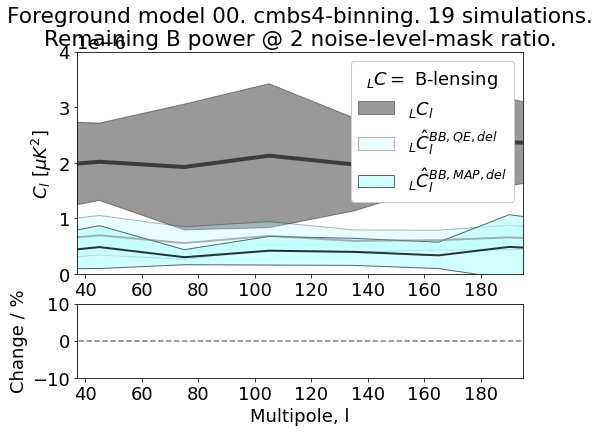

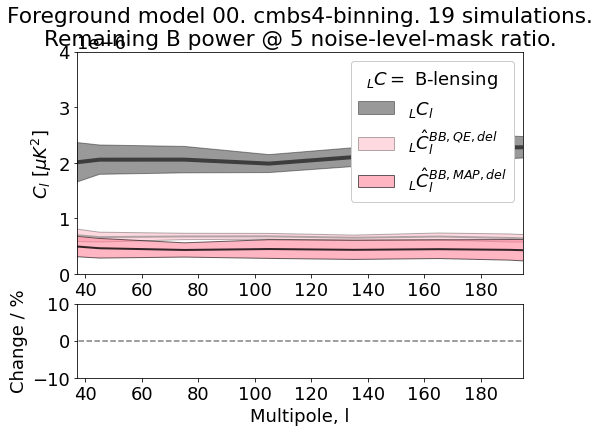

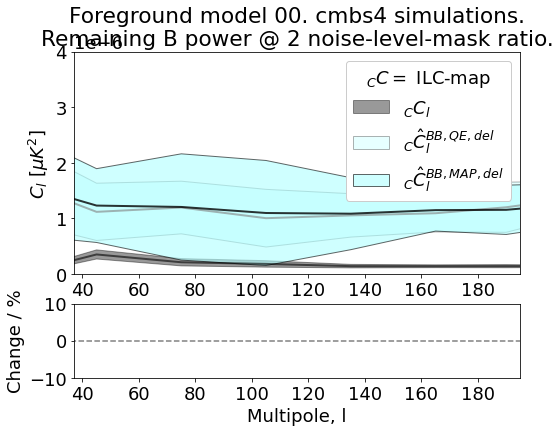

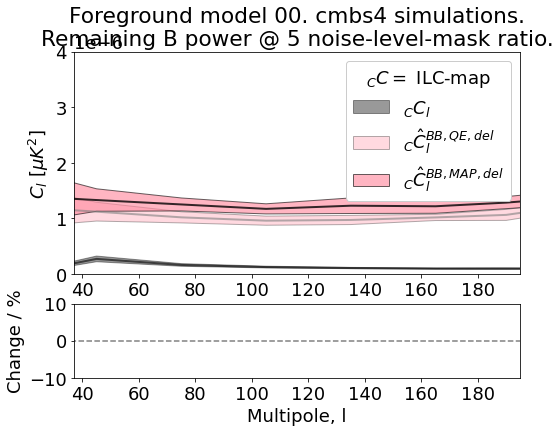

In [19]:
plot_outpath = '/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/'
if not os.path.exists(plot_outpath):
    os.makedirs(plot_outpath)

label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1

def plot_ratio(a, bclQE_L_ratio, bclMAP_L_ratio, bclQE_cs_ratio, bclMAP_cs_ratio, baseBmap, nlevi, fgi):
    # xshift = 1
    ms = 10
    alpha = 1.#(nlevi+1)/(len(nlevels_loc)+1)
    if fgi == 0:
        col = colorscale(colors[nlevi], 1.3)
    elif fgi == 1:
        col = colorscale(colors[nlevi], 1.0)
    elif fgi == 2:
        col = colorscale(colors[nlevi], 0.6)
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2
                       
        x, mean, std = get_ms(bclQE_L_ratio*100, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.6, lw=2)
        
        x, mean, std = get_ms(bclMAP_L_ratio*100, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.8, lw=2)

    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        x, mean, std = get_ms(bclQE_cs_ratio*100, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.6, lw=1)

        x, mean, std = get_ms(bclMAP_cs_ratio*100, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.8, lw=1)


def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, 
                 bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi, fgi, color=''):
    ms = 10
    alpha = 1.#(nlevi+1)/(len(nlevels_loc)+1)
    if color =='':
        label_suffix = ''
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
    else:
        col = 'grey'
        label_suffix = ' mf-sub'
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2             
        x, mean, std = get_ms(bcl_L_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, 
         label=label_f, color='black', alpha=0.4, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.6, lw=4)

        x, mean, std = get_ms(bcl_Llensc_QE_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.6, lw=2)
        
        x, mean, std = get_ms(bcl_Llensc_MAP_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.8, lw=2)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        if color =='':
            x, mean, std = get_ms(bcl_cs_jm*ct, binspace=binspace)
            a.fill_between(x, mean+std, mean-std, label=label_cs, color='black', alpha=0.4, edgecolor='black')
            a.plot(x, mean, color='black', alpha=0.6, lw=2)
            # a.plot(x, mean, color='red', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_cslensc_QE_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.6, lw=2)
        # a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.8, lw=2)
        # a.plot(x, mean, color='yellow', alpha=alpha, lw=1)


for bB in ['L', 'C']:
    for fgi, fg in enumerate(fgs):
        label_f = r'$_{{L}}C_l$'
        label_cs = r'$_{{C}}C_l$'
        label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
        label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        for nlevi, nlev in enumerate(nlevels_loc):
            fig, ax = plt.subplots(2,1,figsize=[8, 6])
            gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
            ax[0] = plt.subplot(gs[0])
            ax[1] = plt.subplot(gs[1])
        # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
            # nlevi=7
            baseBmap = bB
            label_f = None
            label_QE = ''
            label_MAP = ''
            label_cs = ''
            if True:#nlevi == len(nlevels[-2:]) - 1:
                label_f = r'$_{{L}}C_l$'
                label_cs = r'$_{{C}}C_l$'
                label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
                label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
            plot_content(
                ax[0],
                bcl_cs_nm[fgi][nlevi], bcl_L_nm[fgi][nlevi],
                bcl_Llensc_QE_nm[fgi][nlevi], bcl_cslensc_QE_nm[fgi][nlevi],
                bcl_Llensc_MAP_nm[fgi][nlevi], bcl_cslensc_MAP_nm[fgi][nlevi],
                baseBmap, nlevi, fgi)
            # plot_ratio(
            #     ax[1],
            #     1-bcl_Llensc_QE_nm[fgi][nlevi]/bcl_Llensc_mm_QE_nm[fgi][nlevi], 1-bcl_Llensc_MAP_nm[fgi][nlevi]/bcl_Llensc_mm_MAP_nm[fgi][nlevi],
            #     1-bcl_cslensc_QE_nm[fgi][nlevi]/bcl_cslensc_mm_QE_nm[fgi][nlevi], 1-bcl_cslensc_MAP_nm[fgi][nlevi]/bcl_cslensc_mm_MAP_nm[fgi][nlevi], baseBmap, nlevi, fgi)
            
            ax[0].set_xlim((37.,lmax_plot))
            ax[0].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=18)
            
            ax[1].set_xlabel(r'Multipole, l', fontsize=18)
            ax[1].set_ylabel(r'Change / %', fontsize=18)
            ax[1].set_ylim((-10,10))
            ax[1].set_xlim((37.,lmax_plot))
            ax[1].hlines(0.,0,200, ls='--', color='grey')
            if baseBmap == 'L': 
                ax[0].set_ylim((0.0e-6,4e-6))
                ax[0].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper right', framealpha=1.0)
                # ax.set_title('Foreground model {}. {}-binning. Ensemble average over {} simulations.\n'.format(fg, binid, len(simids)) + r'Remaining B power @ {} - {} noise-level-mask ratio.'.format(nlevels_loc[0], nlevels_loc[-1]))
                ax[0].set_title('Foreground model {}. {}-binning. {} simulations.\n'.format(fg, binid, len(simids)) + r'Remaining B power @ {} noise-level-mask ratio.'.format(nlev))

            else:
                ax[0].set_ylim((0.0e-6,4e-6))
                ax[0].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper right', framealpha=1.0)
                # ax.set_title('Foreground model {}. Ensemble average over {} simulations.\n'.format(fg, binid, len(simids)) + 'Remaining B power @ {} - {} noise-level-mask ratio.'.format(nlevels_loc[0], nlevels_loc[-1]))
                ax[0].set_title('Foreground model {}. {} simulations.\n'.format(fg, binid, len(simids)) + 'Remaining B power @ {} noise-level-mask ratio.'.format(nlev))

                # ax.set_title(r'Ensemble average - Remaining B power - Subtracting from ILC component separated input $B_{cs}$')
            plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/{}ClBB_ens_avg_fg{}_nlev{}_compare_mfsubtracted.pdf'.format(bB, fg, nlev))


[ 1.2  2.   5.  50. ]


IndexError: index 5 is out of bounds for axis 0 with size 4

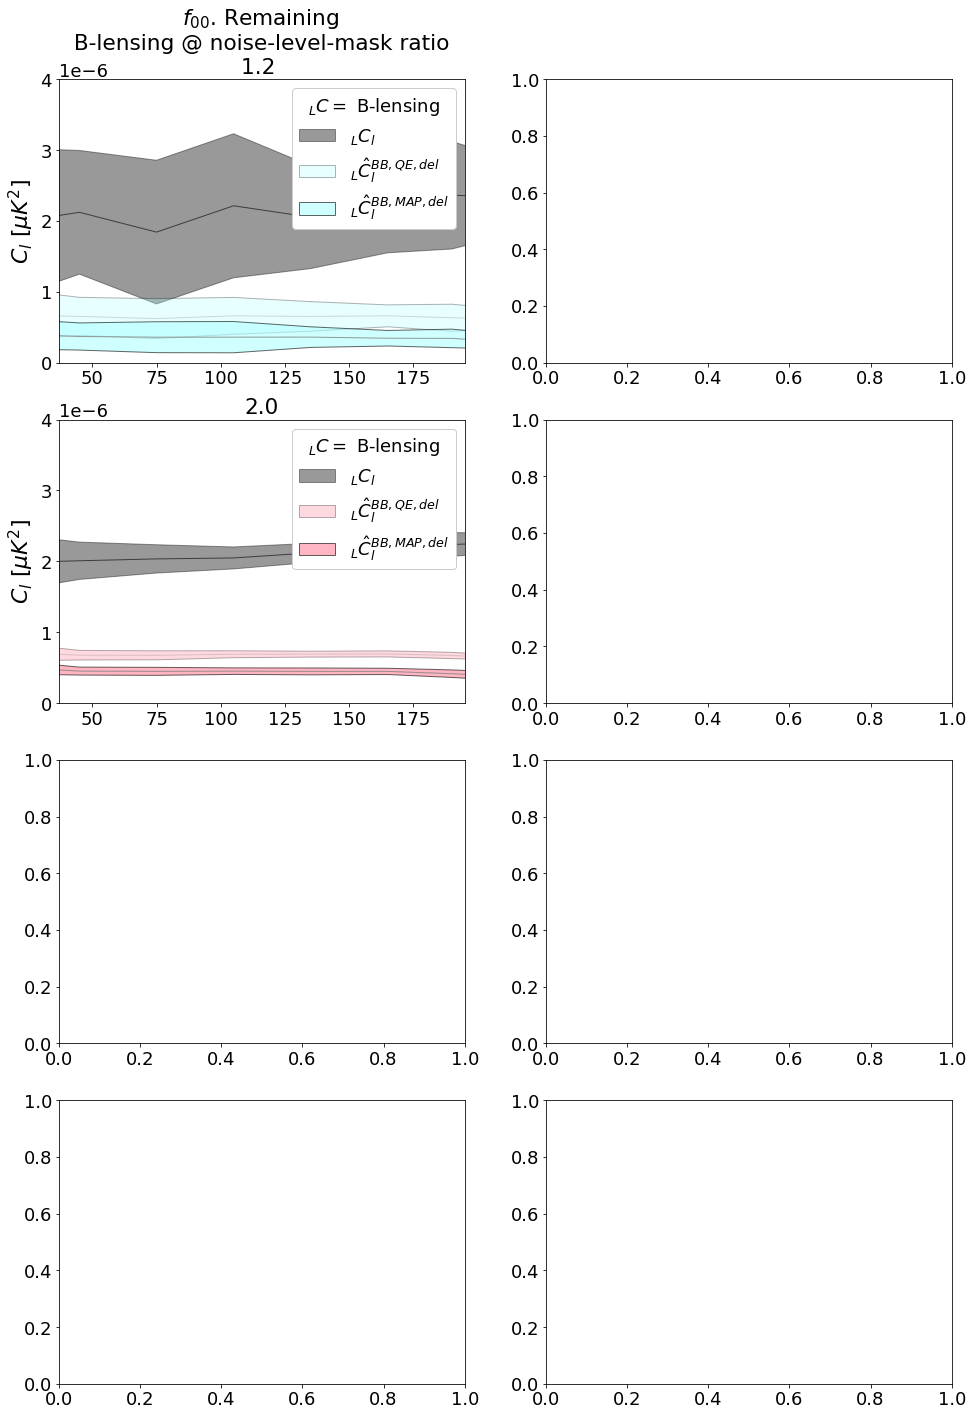

In [16]:
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1
nlevels = [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
nlevi_loc = [0,3,5,7]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))
print(nlevels_loc)
def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, 
                 bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi, fgi, color=''):
    ms = 10
    alpha = 1.#(nlevi+1)/(len(nlevels_loc)+1)
    if color =='':
        label_suffix = ''
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
    else:
        col = 'grey'
        label_suffix = ' mf-sub'
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2             
        x, mean, std = get_ms(bcl_L_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, 
         label=label_f, color='black', alpha=0.4, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.6, lw=1)

        x, mean, std = get_ms(bcl_Llensc_QE_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        
        x, mean, std = get_ms(bcl_Llensc_MAP_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        if color =='':
            x, mean, std = get_ms(bcl_cs_jm*ct, binspace=binspace)
            a.fill_between(x, mean+std, mean-std, label=label_cs, color='black', alpha=0.4, edgecolor='black')
            a.plot(x, mean, color='black', alpha=0.6, lw=1)
            # a.plot(x, mean, color='red', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_cslensc_QE_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        # a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)
        # a.plot(x, mean, color='yellow', alpha=alpha, lw=1)
for fgi, fg in enumerate(fgs):
    fig, ax = plt.subplots(4, 2, figsize=[16,24])
    for bBi, bB in enumerate(['L', 'C']):
        label_f = r'$_{{L}}C_l$'
        label_cs = r'$_{{C}}C_l$'
        label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
        label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        for nlevi, nlev in enumerate(nlevels_loc):
        # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
            # nlevi=7
            baseBmap = bB
            label_f = None
            label_QE = ''
            label_MAP = ''
            label_cs = ''
            if True:#nlevi == len(nlevels[-2:]) - 1:
                label_f = r'$_{{L}}C_l$'
                label_cs = r'$_{{C}}C_l$'
                label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
                label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
            plot_content(
                ax[nlevi,bBi],
                bcl_cs_nm[fgi][nlevi_loc[nlevi]], bcl_L_nm[fgi][nlevi_loc[nlevi]],
                bcl_Llensc_QE_nm[fgi][nlevi_loc[nlevi]], bcl_cslensc_QE_nm[fgi][nlevi_loc[nlevi]],
                bcl_Llensc_MAP_nm[fgi][nlevi_loc[nlevi]], bcl_cslensc_MAP_nm[fgi][nlevi_loc[nlevi]],
                baseBmap, nlevi, fgi)
 
            ax[nlevi][bBi].set_xlim((37.,lmax_plot))
            ax[nlevi][bBi].set_ylim((0.0e-6,4e-6))       
            if baseBmap == 'L':
                if nlevi == 0:
                    ax[nlevi,bBi].set_title('$f_{{{}}}$.'.format(fg, len(simids)) + ' Remaining \n B-lensing @ noise-level-mask ratio \n{} '.format(nlev))
                else:
                    ax[nlevi,bBi].set_title('{}'.format(nlev))
                ax[nlevi,bBi].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper right', framealpha=1.0)
            else:
                if nlevi == 0:
                    ax[nlevi,bBi].set_title('$f_{{{}}}$.'.format(fg, len(simids)) + ' Remaining \n B-power @ noise-level-mask ratio \n{}'.format(nlev))
                else:
                    ax[nlevi,bBi].set_title('{}'.format(nlev))
                ax[nlevi,bBi].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper right', framealpha=1.0)
                # ax.set_title('Foreground model {}. Ensemble average over {} simulations.\n'.format(fg, binid, len(simids)) + 'Remaining B power @ {} - {} noise-level-mask ratio.'.format(nlevels_loc[0], nlevels_loc[-1]))
                
                # ax.set_title(r'Ensemble average - Remaining B power - Subtracting from ILC component separated input $B_{cs}$')
            
            if nlevi == len(nlevels_loc)-1:
                ax[nlevi,bBi].set_xlabel(r'Multipole $\ell$', fontsize=22)
            if bBi == 0:
                ax[nlevi,bBi].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=22)
    plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/ClBB_ens_avg_fg{}_allnlev.pdf'.format(fg))
    plt.show()

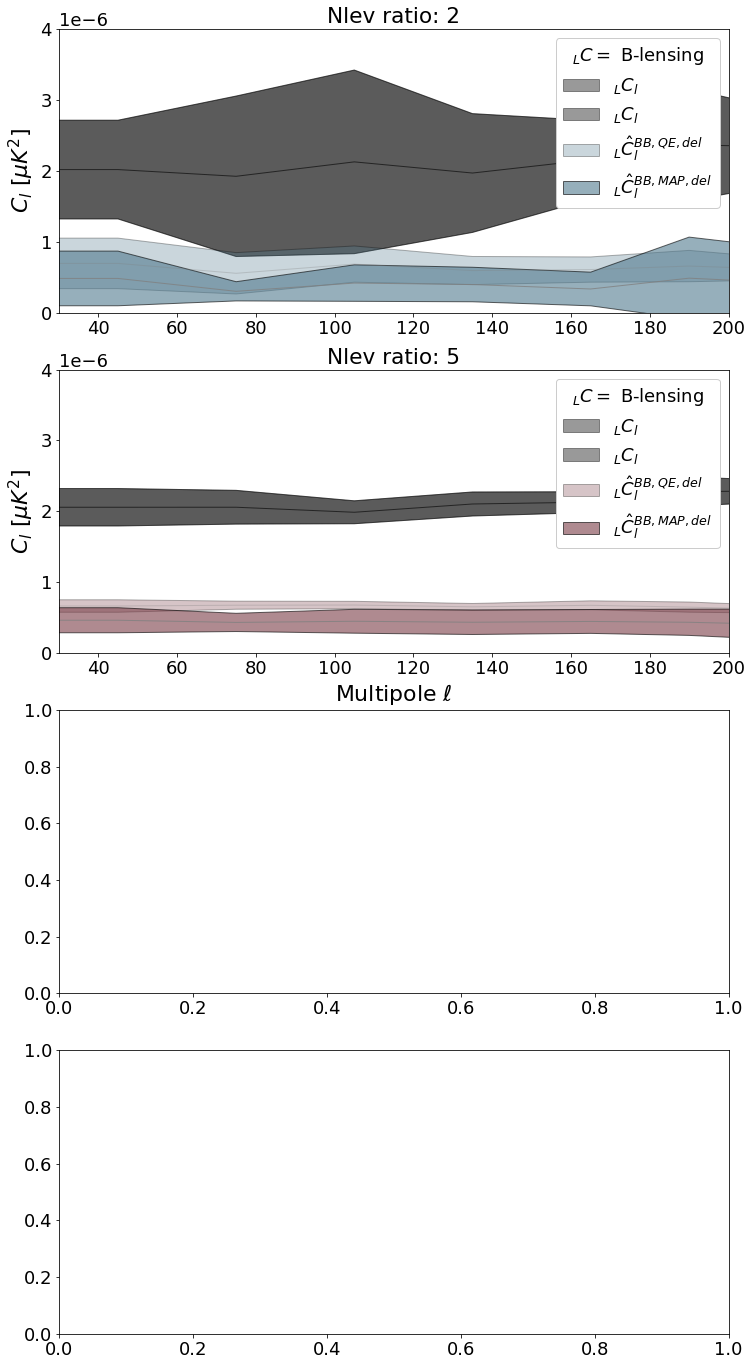

In [20]:
lmax_plot = 200
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1
# nlevels = [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
# nlevi_loc = [0,1]#[0,3,5,7]
# nlevels_loc = np.take(nlevels,np.array(nlevi_loc))

def remove_bin(bins, binidx):
    
    buff = bins[binidx+1]
    bins[binidx] = buff
    return bins
    
    
def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, 
                 bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi, fgi, color=''):
    ms = 10
    alpha = 1.#(nlevi+1)/(len(nlevels_loc)+1)
    if color =='':
        label_suffix = ''
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
    else:
        col = 'grey'
        label_suffix = ' mf-sub'
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2             
        x, mean, std = get_ms(bcl_L_jm*ct, binspace=binspace)
        mean[0] = mean[1]
        std[0] = std[1]
        a.fill_between(x, mean+std, mean-std, 
         label=label_f, color='black', alpha=0.4, edgecolor='black')
        
        x, mean, std = get_ms(bcl_L_jm*ct, binspace=binspace)
        mean[0] = mean[1]
        std[0] = std[1]
        a.fill_between(x, mean+std, mean-std, 
         label=label_f, color='black', alpha=0.4, edgecolor='black')
        
        a.plot(x, mean, color='black', alpha=0.6, lw=1)

        x, mean, std = get_ms(bcl_Llensc_QE_jm*ct, binspace=binspace)
        mean[0] = mean[1]
        std[0] = std[1]
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        
        x, mean, std = get_ms(bcl_Llensc_MAP_jm*ct, binspace=binspace)
        mean[0] = mean[1]
        std[0] = std[1]
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        if color =='':
            x, mean, std = get_ms(bcl_cs_jm*ct, binspace=binspace)
            a.fill_between(x, mean+std, mean-std, label=label_cs, color='black', alpha=0.4, edgecolor='black')
            a.plot(x, mean, color='black', alpha=0.6, lw=1)
            # a.plot(x, mean, color='red', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_cslensc_QE_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        # a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm*ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)
        # a.plot(x, mean, color='yellow', alpha=alpha, lw=1)
for fgi, fg in enumerate(fgs):
    fig, ax = plt.subplots(4, 1, figsize=[12,24])
    for bBi, bB in enumerate(['L']):
        label_f = r'$_{{L}}C_l$'
        label_cs = r'$_{{C}}C_l$'
        label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
        label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        for nlevi, nlev in enumerate(nlevels_loc):
        # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
            # nlevi=7
            baseBmap = bB
            label_f = None
            label_QE = ''
            label_MAP = ''
            label_cs = ''
            if True:#nlevi == len(nlevels[-2:]) - 1:
                label_f = r'$_{{L}}C_l$'
                label_cs = r'$_{{C}}C_l$'
                label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
                label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
            plot_content(
                ax[nlevi],
                bcl_cs_nm[fgi][nlevi_loc[nlevi]], bcl_L_nm[fgi][nlevi_loc[nlevi]],
                bcl_Llensc_QE_nm[fgi][nlevi_loc[nlevi]], bcl_cslensc_QE_nm[fgi][nlevi_loc[nlevi]],
                bcl_Llensc_MAP_nm[fgi][nlevi_loc[nlevi]], bcl_cslensc_MAP_nm[fgi][nlevi_loc[nlevi]],
                baseBmap, nlevi, fgi+2)
 
            ax[nlevi].set_xlim((30.,lmax_plot))
            ax[nlevi].set_ylim((0.0e-6,4e-6))       
            if baseBmap == 'L':
                # if nlevi == 0:
                #     ax[nlevi].set_title('$f_{{{}}}$.'.format(fg, len(simids)) + ' Remaining \n B-lensing @ noise-level-mask ratio \n{} '.format(nlev))
                # else:
                #     ax[nlevi].set_title('{}'.format(nlev))
                ax[nlevi].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper right', framealpha=1.0)
            else:
                # if nlevi == 0:
                #     ax[nlevi].set_title('$f_{{{}}}$.'.format(fg, len(simids)) + ' Remaining \n B-power @ noise-level-mask ratio \n{}'.format(nlev))
                # else:
                #     ax[nlevi].set_title('{}'.format(nlev))
                ax[nlevi].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper right', framealpha=1.0)
                # ax.set_title('Foreground model {}. Ensemble average over {} simulations.\n'.format(fg, binid, len(simids)) + 'Remaining B power @ {} - {} noise-level-mask ratio.'.format(nlevels_loc[0], nlevels_loc[-1]))
                
                # ax.set_title(r'Ensemble average - Remaining B power - Subtracting from ILC component separated input $B_{cs}$')
            ax[nlevi].set_title('Nlev ratio: {}'.format(nlev))
            if nlevi == len(nlevels_loc)-1:
                ax[nlevi].set_xlabel(r'Multipole $\ell$', fontsize=22)
            if bBi == 0:
                ax[nlevi].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=22)
            if baseBmap == 'L':
                plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/ClBlens_ens_avg_fg{}_allnlev_notitle.pdf'.format(fg), bbox_inches='tight')
            else:
                plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/ClBWf_ens_avg_fg{}_allnlev_notitle.pdf'.format(fg), bbox_inches='tight')
        plt.show()
lmax_plot=200

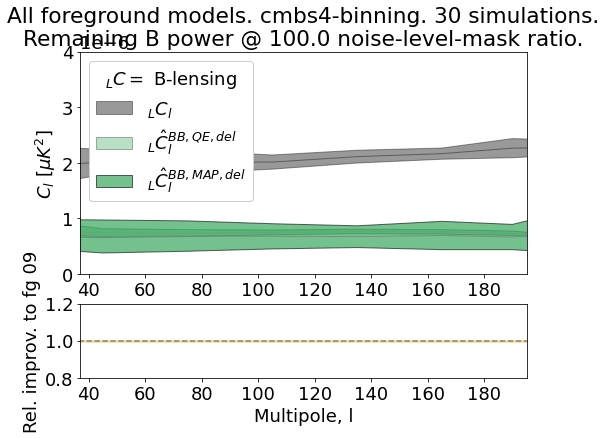

In [37]:
#Testing baseline nlev plots

import matplotlib.gridspec as gridspec
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1

nlevels_loc = nlevels# np.take(nlevels,np.array([0,3,5,7]))
def plot_content(
    a, 
    bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm,
    bcl_cslensc_QE_jm, bcl_Llensc_MAP_jm,
    bcl_cslensc_MAP_jm, baseBmap, fgi):
    # xshift = 1
    ms = 10
    alpha = 1.#(nlevi+1)/(len(nlevels_loc)+1)
    if fgi == 0:
        fg_mod = 1.3
    elif fgi == 1:
        fg_mod = 1.0
    elif fgi == 2:
        fg_mod = 0.6
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        nlevi_bl = len(nlevels_loc)-1
        
        x, mean, std = get_ms(bcl_L_jm[nlevi_bl]*ct, binspace=binspace)
        a[0].fill_between(x, mean+std, mean-std, 
            label=label_f, color='black', alpha=0.4, edgecolor='black')
        a[0].plot(x, mean, color='black', alpha=0.4, lw=1)
        
#         x, mean, std = get_ms(bcl_L_jm[1]*ct, binspace=binspace)
#         a[0].fill_between(x, mean+std, mean-std, 
#             label=label_f, color='black', alpha=0.4, edgecolor='black')
#         a[0].plot(x, mean, color='black', alpha=0.4, lw=1)
        
#         x, mean, std = get_ms(bcl_L_jm[2]*ct, binspace=binspace)
#         a[0].fill_between(x, mean+std, mean-std, 
#             label=label_f, color='black', alpha=0.4, edgecolor='black')
#         a[0].plot(x, mean, color='black', alpha=0.4, lw=1)
        
        
        col = colorscale(colors[nlevi_bl], fg_mod)
        x, mean, std = get_ms(bcl_Llensc_QE_jm[nlevi_bl]*ct, binspace=binspace)
        #colors2[nlevi+len(simids)]
        a[0].fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a[0].plot(x, mean, color='grey', alpha=0.3, lw=1)
        
        col = colorscale(colors[nlevi_bl], fg_mod)
        x, mean, std = get_ms(bcl_Llensc_MAP_jm[nlevi_bl]*ct, binspace=binspace)
        a[0].fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a[0].plot(x, mean, color='grey', alpha=0.8, lw=1)
        
        for nlevi, nlev in enumerate(nlevels_loc[:-1]):
            x, mean, std = get_ms(bcl_Llensc_QE_jm[nlevi]/bcl_Llensc_QE_jm[nlevi_bl], binspace=binspace)
            col = colorscale(colors[nlevi], fg_mod)
            # a[1].fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
            a[1].plot(x, mean, color=col, alpha=0.3, lw=2)

            x, mean, std = get_ms(bcl_Llensc_MAP_jm[nlevi]/bcl_Llensc_MAP_jm[nlevi_bl], binspace=binspace)
            col = colorscale(colors[nlevi], fg_mod)
            # a[1].fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
            a[1].plot(x, mean, color=col, alpha=0.6, lw=3)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
   
        x, mean, std = get_ms(bcl_cs_jm[2]*ct, binspace=binspace)
        a[0].fill_between(x, mean+std, mean-std, label=label_cs, color='black', alpha=0.6, edgecolor='black')
        a[0].plot(x, mean, color='black', alpha=0.6, lw=1)
        # a[0].plot(x, mean, color='red', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_cslensc_QE_jm[2]*ct, binspace=binspace)
        a[0].fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a[0].plot(x, mean, color='grey', alpha=0.3, lw=1)
        # a[0].plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm[2]*ct, binspace=binspace)
        a[0].fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a[0].plot(x, mean, color='grey', alpha=0.8, lw=1)
        # a[0].plot(x, mean, color='yellow', alpha=alpha, lw=1)
        
        x0007, mean0007, std0007 = get_ms(bcl_cslensc_QE_jm[1]/bcl_cslensc_QE_jm[0], binspace=binspace)
        x0009, mean0009, std0009 = get_ms(bcl_cslensc_QE_jm[2]/bcl_cslensc_QE_jm[0], binspace=binspace)
        col = colorscale(colors[nlevi], 1.0)
        # a[1].fill_between(x0007, mean0007+std0007, mean0007-std0007, label=label_MAP.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a[1].plot(x0007, mean0007, color=col, alpha=0.3, lw=2)
        col = colorscale(colors[nlevi], 0.6)
        # a[1].fill_between(x0009, mean0009+std0009, mean0009-std0009, label=label_MAP.format(baseBmap), color=col, alpha=0.3, edgecolor='black')
        a[1].plot(x0009, mean0009, color=col, alpha=0.3, lw=2)
        
        
        x0007, mean0007, std0007 = get_ms(bcl_cslensc_MAP_jm[1]/bcl_cslensc_MAP_jm[0], binspace=binspace)
        x0009, mean0009, std0009 = get_ms(bcl_cslensc_MAP_jm[2]/bcl_cslensc_MAP_jm[0], binspace=binspace)
        col = colorscale(colors[nlevi], 1.0)
        # a[1].fill_between(x0007, mean0007+std0007, mean0007-std0007, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a[1].plot(x0007, mean0007, color=col, alpha=0.6, lw=1)
        col = colorscale(colors[nlevi], 0.6)
        # a[1].fill_between(x0009, mean0009+std0009, mean0009-std0009, label=label_MAP.format(baseBmap), color=col, alpha=0.6, edgecolor='black')
        a[1].plot(x0009, mean0009, color=col, alpha=0.6, lw=1)


for bB in ['L']:#, 'C']:
    baseBmap = bB
    label_f = r'$_{{L}}C_l$'
    label_cs = r'$_{{C}}C_l$'
    label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
    label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
    for fgi, fg in enumerate(fgs):
        fig, ax = plt.subplots(2,1, figsize=[8, 6],sharex=True)
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        ax[0] = plt.subplot(gs[0])
        ax[1] = plt.subplot(gs[1])

        plot_content(
         ax,
         bcl_cs_nm[fgi,:], bcl_L_nm[fgi,:],
         bcl_Llensc_QE_nm[fgi,:], bcl_cslensc_QE_nm[fgi,:],
         bcl_Llensc_MAP_nm[fgi,:], bcl_cslensc_MAP_nm[fgi,:],
         baseBmap, fgi)

        ax[0].set_xlim((37.,lmax_plot))
        ax[1].set_ylim((0.8,1.2))
        ax[1].set_xlim((37.,lmax_plot))
        ax[1].hlines(1,0,200, ls='--', color='grey')
            
        ax[1].set_xlabel(r'Multipole, l', fontsize=18)
        ax[0].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=18)
        ax[1].set_ylabel(r'Rel. improv. to fg 09', fontsize=18)
        if baseBmap == 'L': 
            ax[0].set_ylim((0.0e-6,4e-6))
            ax[0].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper left', framealpha=1.0)
            ax[0].set_title('All foreground models. {}-binning. {} simulations.\n'.format(binid, len(simids)) + r'Remaining B power @ {} noise-level-mask ratio.'.format(nlev))

        else:
            ax[0].set_ylim((0.0e-6,4e-6))
            ax[0].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper left', framealpha=1.0)
            ax[0].set_title('All foreground models. {} simulations.\n'.format(binid, len(simids)) + 'Remaining B power @ {} noise-level-mask ratio.'.format(nlev))

        # plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/{}ClBB_ens_avg_fg{}_nlev{}.pdf'.format(bB, fg, nlev))

(3, 8, 500, 16)


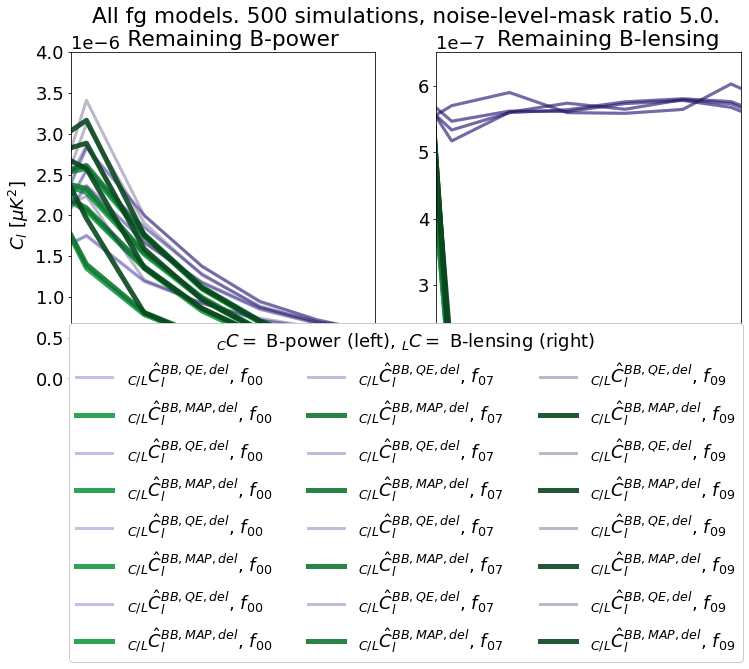

In [28]:
#Testing baseline nlev plots

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1
nlevels = [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
nlevi_loc = [0,3,5,7]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))

def plot_content(a, bcl_QE_jm, bcl_MAP_jm, fgi):
    if fgi == 0:
        fg_label = r', $f_{00}$'
        fg_mod = 1.3
    elif fgi == 1:
        fg_label = r', $f_{07}$'
        fg_mod = 1.0
    elif fgi == 2:
        fg_label = r', $f_{09}$'
        fg_mod = 0.6
        
    l_QE = label_QE + fg_label
    l_MAP = label_MAP + fg_label

    x, mean, std = get_ms(bcl_QE_jm*ct, binspace=binspace)
    col = colorscale(colors[4], fg_mod)
    a.plot(x, mean, color=col, alpha=0.3, lw=3, label=l_QE)

    x, mean, std = get_ms(bcl_MAP_jm*ct, binspace=binspace)
    col = colorscale(colors[3], fg_mod)
    a.plot(x, mean, color=col, alpha=0.9, lw=5, label=l_MAP)

fig, ax = plt.subplots(1,2, figsize=[12, 6])

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'
label_QE = r'$_{C/L}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{C/L}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
print(bcl_cslensc_QE_nm.shape)
for fgi, fg in enumerate(fgs):
    nlevi = 5
    # for nlevi in range(len(nlevels_loc)):
    plot_content(
     ax[0],
     bcl_cslensc_QE_nm[fgi,nlevi], bcl_cslensc_MAP_nm[fgi,nlevi], fgi)

    plot_content(
     ax[1],
     bcl_Llensc_QE_nm[fgi,nlevi], bcl_Llensc_MAP_nm[fgi,nlevi], fgi)

    ax[0].set_xlim((37.,lmax_plot))
    ax[0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    ax[1].set_xlim((37.,lmax_plot))
    ax[1].set_xlabel(r'Multipole, $\ell$', fontsize=18)


    ax[0].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=18)
    ax[0].set_ylim((0.0e-6,4e-6))
    ax[1].set_ylim((1.6e-7,6.5e-7))
            
plt.legend(title=r'$_{{{}}}C=$ B-power (left), $_{{{}}}C=$ B-lensing (right)'.format('C','L'), ncol=3, loc='center', framealpha=1.0, bbox_to_anchor=[-0.1,-0.35])
plt.title('All fg models. {} simulations,'.format(len(simids)) + ' noise-level-mask ratio {}.\n     Remaining B-power                       Remaining B-lensing'.format(nlevels[5]), x=-0.1)
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/ClBB_ens_avg_allfg_nlev50.pdf', bbox_inches='tight')

IndexError: index 1 is out of bounds for axis 1 with size 1

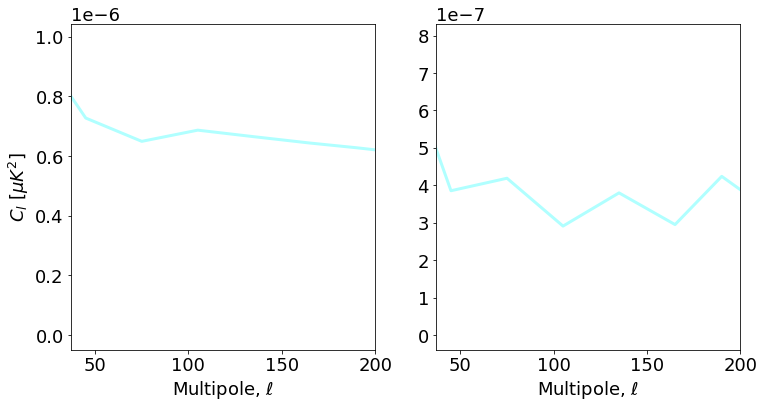

In [102]:
#Testing baseline nlev plots

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1
nlevels = [2.,5., 10., 100.]
nlevi_loc = [0,1,2,3]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))
colbi = 11

plotlines = []
plotlines_fg = []

def plot_content(a, bc_jm, fgi, nlevi):
    if fgi == 0:
        fg_label = r', $f_{00}$'
        fg_mod = 1.3
    elif fgi == 1:
        fg_label = r', $f_{07}$'
        fg_mod = 1.0
    elif fgi == 2:
        fg_label = r', $f_{09}$'
        fg_mod = 0.6

    x, mean, std = get_ms(bc_jm*ct, binspace=binspace)
    col = colorscale(colors[nlevi], fg_mod)
    col_black = colorscale(colors[colbi], fg_mod)
    l1, = a.plot(x, mean, color=col, lw=3, label=nlevels_loc[nlevi])
    l2, = a.plot([], [], color=col_black, label=None, lw=3)
    return l1, l2
    # x, mean, std = get_ms(bcl_MAP_jm*ct, binspace=binspace)
    # col = colorscale(colors[3], fg_mod)
    # a.plot(x, mean, color=col, alpha=0.9, lw=5, label=l_MAP)

fig, ax = plt.subplots(1,2, figsize=[12, 6])

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'
label_QE = r'$_{L}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{L}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'

for fgi, fg in enumerate(fgs):
    for nlevi in range(len(nlevels_loc)):
        l1, l2 = plot_content(
         ax[0],
         bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi]], fgi, nlevi)
        
        if fgi==1:
            plotlines.append(l1)
        if nlevi == 0:
            plotlines_fg.append(l2)

        plot_content(
         ax[1],
         bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi]], fgi, nlevi)

        ax[0].set_xlim((37.,lmax_plot))
        ax[0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
        ax[1].set_xlim((37.,lmax_plot))
        ax[1].set_xlabel(r'Multipole, $\ell$', fontsize=18)

        ax[0].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=18)
        # ax[0].set_ylim((5.3e-7,7.5e-7))
        # ax[1].set_ylim((1e-7,4e-7))

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(plotlines, labels, loc='center', title='nlev mask ratio', bbox_to_anchor=[0.5, 0.5], framealpha=0.8)
leg3 = ax[1].legend(plotlines_fg, [fg for fg in fgs], title='Fg-model', loc='center', framealpha=0.8)
plt.title('QE and MAP delensed ensemble average. {} simulations.'.format(len(simids)) + '\n         QE'+' '*50+'MAP', x=-0.1)
plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/ClBB_ens_avg_allfg_allnlev.pdf', bbox_inches='tight')

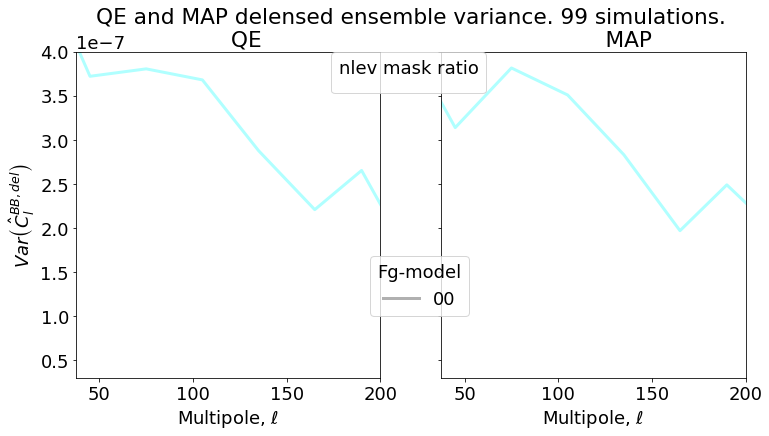

In [104]:
nlevels = [2.,5., 10., 100.]
nlevi_loc = [0]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))
colors2 = np.array([cmap(nlevi/(len(nlevels))) for nlevi in range(len(nlevels))])
fig, ax = plt.subplots(1,2, figsize=[12, 6],sharex=True, sharey=True)
plotlines = []
plotlines_fg = []
colbi = 11
for fgi in range(len(fgs)):
    for nlevi in range(len(nlevels_loc)):
        ls = '-'
        if fgi == 0:
            label = '{}'.format(nlevels_loc[nlevi])
            #ls = '-'
            col = colorscale(colors[nlevi], 1.3)
            col_black = colorscale(colors[colbi], 1.3)
        elif fgi==1:
            label = ''
            #ls = '--'
            col = colorscale(colors[nlevi], 1.0)
            col_black = colorscale(colors[colbi], 1.0)
        else:
            label = ''
            #ls = ':'
            col = colorscale(colors[nlevi], 0.6)
            col_black = colorscale(colors[colbi], 0.6)

        # l1, = ax[0].plot(edges_center, bcl_var[fgi,1,nlevi_loc[nlevi]]/bcl_var[fgi,0,nlevi_loc[nlevi]],
        #                  color=col, ls = ls, label=label, lw=1)
        # l2, = ax[1].plot(edges_center, bcl_var[fgi,2,nlevi_loc[nlevi]]/bcl_var[fgi,0,nlevi_loc[nlevi]],
        #                  color=col, ls = ls, label=label, lw=3)
        
        # l0, = ax[0].plot(edges_center, bcl_var[fgi,0,nlevi], color=col, ls = ls, label=label, lw=3)
        
        l1, = ax[0].plot(edges_center, bcl_var[fgi,1,nlevi_loc[nlevi]], color=col, ls=ls, label=label, lw=3)
        l2, = ax[1].plot(edges_center, bcl_var[fgi,2,nlevi_loc[nlevi]], color=col, ls=ls, label=label, lw=3)
        l3, = ax[1].plot([], [], color=col_black, ls=ls, label=None, lw=3)

        if fgi==1:
            plotlines.append(l2)
        if nlevi == 0:
            plotlines_fg.append(l3)
ax[0].set_xlim(37.5,lmax_plot)
ax[0].set_ylim(0.3e-7,.4e-6)
ax[0].set_xlabel('Multipole, $\ell$', fontsize=18)
ax[1].set_xlabel('Multipole, $\ell$', fontsize=18)
ax[0].set_ylabel(r'$Var\left(_{{{}}}\hat{{C}}_{{l}}^{{BB,del}}\right)$', fontsize=18)
# ax[0].set_ylabel(r'$Var\left(C\left(\frac{_{{L}}B-B^{temp}}{_{{L}}B}\right)\right)$', fontsize=14)
# plt.yscale('log')
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(plotlines, labels, loc='upper center', title='nlev mask ratio', bbox_to_anchor=[0.51, 0.9], framealpha=0.8)

leg3 = plt.legend(plotlines_fg, [fg for fg in fgs], title='Fg-model', loc=1, bbox_to_anchor=[.12,0.4], framealpha=0.8)

plt.title('QE and MAP delensed ensemble variance. {} simulations.'.format(len(simids)) + '\n         QE'+' '*50+'MAP', x=-0.1)
plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/ClBBQEMAP_var_allfg.pdf'.format(fg), bbox_inches='tight')

## Delensing efficiency

IndexError: index 2 is out of bounds for axis 1 with size 2

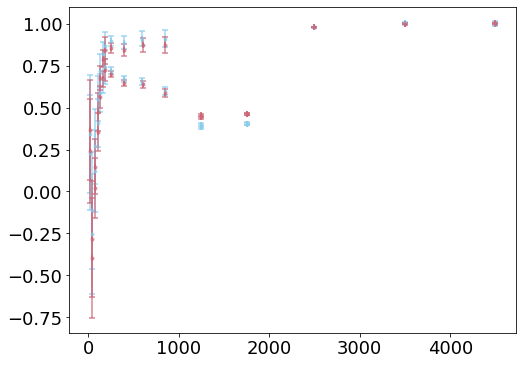

In [24]:
label_f_QE = r'$1-A_l^{QE}$'
label_QE_L = r'$1-_{L}A_l^{QE}$'
label_QE_C = r'$1-_{C}A_l^{QE}$'

label_MAP_L = r'$1-_{L}A_l^{MAP}$'
label_MAP_C = r'$1-_{C}A_l^{MAP}$'

lmax_loc=256+1
bl = edges
bu = edges[1:]
blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 10
nlevi_loc = [0,1,2,3]
dataarr = np.array([bcl_Llensc_QE_nm, bcl_cslensc_QE_nm, bcl_Llensc_MAP_nm, bcl_cslensc_MAP_nm])
i=0
xerr = np.array([0]).T
fig, ax = plt.subplots(figsize=[8, 6])
for fgi, fg in enumerate(fgs):
    for nlevi, nlev in enumerate(nlevels):
        idx = 0
        xshift = -delx/((len(dataarr)*len(nlevels))/2) + i*delx/(len(dataarr)*len(nlevels))
        
        x, mean, std = get_ms(1-np.array([bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        ax.errorbar(xshift+x, mean, yerr=std, xerr=xerr.T, label=label_MAP_L, color=colors[nlevi], alpha=0.6, lw=2, fmt='.', capsize=3, capthick=2, fillstyle='full')
        label_MAP_L= ''

        x, mean, std = get_ms(1-np.array([bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        ax.errorbar(xshift+x, mean, yerr=std, xerr=xerr.T, label=label_MAP_L, color=colors[nlevi], alpha=0.6, lw=2, fmt='.', capsize=3, capthick=2, fillstyle='full')
        # if colorid == 1:
        #     ax.errorbar(xshift+cedge_center[1:], cmean[1:], yerr=cstd[1:], xerr=cxerr[:,1:], label=label_MAP_C, color=colors[colorid], alpha=0.6, lw=2, fmt='.', capsize=3, capthick=2, fillstyle='full')
        #     label_MAP_C = ''
        idx +=1
        i+=1
ax.set_xlim((2,lmax_plot))
ax.set_ylim((0.005,.5))
ax.set_xlabel(r'multipole, $l$', fontsize=14)
ax.set_ylabel(r'$1-A_l$', fontsize=14)
ax.legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=12)
ax.set_title('Ensemble average\n'.format(2*simidx+1) + r'Delensing efficiency.')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/delens_eff.pdf')

In [52]:
label_f_QE = r'$1-A_l^{QE}$'
label_QE_L = r'$1-_{L}A_l^{QE}$'
label_QE_C = r'$1-_{C}A_l^{QE}$'

label_MAP_L = r'$1-_{L}A_l^{MAP}$'
label_MAP_C = r'$1-_{C}A_l^{MAP}$'

# nlevels = [2.,5.,10.,100.]
nlevi_loc = [0,3,5,7]
# nlevi_loc = [0,1,2,3]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))

lmax_loc=256+1
bl = edges[:-1]
bu = edges[1:]

blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 40
diffx = (bu - bl)/2
xerr = diffx
nrow, ncol = 2,2
# fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
plotlines = []
plotlines_fg = []

def skf(d):
    return d[1:]


    
    fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
for nlevi, nlev in enumerate(nlevels_loc):
    i=0
    for fgi, fg in enumerate(fgs):
        label_QE_L, label_MAP_L = '',''
        idx = 0
        xshift = -delx/(len(nlevels)/2) + i*delx/(len(nlevels))
        if fgi == 0:
            col_black = colorscale(colors[11], 1.3)
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            label_QE_L = r'$1-_{L}A_l^{QE}$'
            label_MAP_L = r'$1-_{L}A_l^{MAP}$'
            col_black = colorscale(colors[11], 1.0)
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col_black = colorscale(colors[11], 0.6)
            col = colorscale(colors[nlevi], 0.6)

        x, mean, std = get_ms(1-np.array([bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        ax[nlevi%nrow][int(nlevi/ncol)].errorbar(skf(xshift+x), skf(mean), yerr=skf(std), xerr=skf(xerr), label=label_QE_L, color=col, alpha=0.2, lw=2, fmt='x', capsize=3, capthick=2, fillstyle='full')

        x, mean, std = get_ms(1-np.array([bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        # print(mean)
        l2 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(skf(xshift+x), skf(mean), yerr=skf(std), xerr=skf(xerr), label=label_MAP_L, color=col, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        l3 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1, 1, yerr=1, xerr=1, label=None, color=col_black, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
       
        if nlevi == 0:
            plotlines_fg.append(l3)
        if fgi==1:
            plotlines.append(l2)
        i+=1
        label_QE_L, label_MAP_L = '',''
    ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=18)
    ax[nlevi%nrow][int(nlevi/ncol)].set_xlim((2,lmax_plot))
    ax[nlevi%nrow][int(nlevi/ncol)].set_ylim((0.4,1))
    
    leg1 = ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=1, fontsize=14)
ax[1][0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
ax[1][1].set_xlabel(r'Multipole, $\ell$', fontsize=18)
ax[0][1].set_xlim((30,200))
ax[1][1].set_xlabel((30,200))
ax[0][0].set_ylabel(r'$1-A_l$', fontsize=18)
ax[1][0].set_ylabel(r'$1-A_l$', fontsize=18)
ax[0][1].set_title('Delensing efficiency over {} simulations\n'.format(len(simids)), x=-0.1)

leg2 = plt.legend(plotlines, [nlev for nlev in nlevels_loc], title='nlev mask ratio', loc=1, bbox_to_anchor=[0.35,1.5])
leg3 = plt.legend(plotlines_fg, [fg for fg in fgs], title='Fg-model', loc=1, bbox_to_anchor=[0.2,0.5])
# plt.legend([l for l in plotlines], loc=4)
plt.gca().add_artist(leg3)
plt.gca().add_artist(leg2)
plt.gca().add_artist(leg1)
plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/delens_eff_allfg_allnlev.pdf'.format(fg, nlev))

IndexError: index 3 is out of bounds for axis 0 with size 3

[0.73976243 0.76500329 0.78109358 0.72833522 0.78197272 0.7720451
 0.75125622 0.72972537 0.69178439 0.68142013 0.6537671  0.14886932
 0.2208827  0.97167859 0.99924912 0.99898589]
[0.71252262 0.76021028 0.73256632 0.74472132 0.74403284 0.74848508
 0.75255237 0.75079359 0.71234205 0.68807051 0.63877668 0.14657368
 0.22273481 0.97156086 1.00008256 1.00009437]


ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

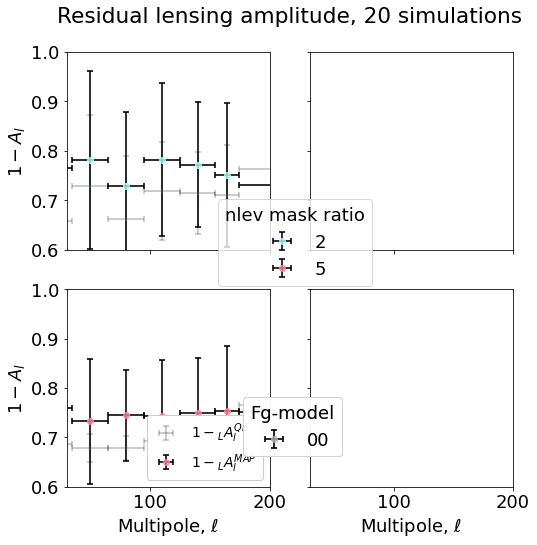

In [53]:
label_f_QE = r'$1-A_l^{QE}$'
label_QE_L = r'$1-_{L}A_l^{QE}$'
label_QE_C = r'$1-_{C}A_l^{QE}$'

label_MAP_L = r'$1-_{L}A_l^{MAP}$'
label_MAP_C = r'$1-_{C}A_l^{MAP}$'

# nlevels = [2.,5.,10.,100.]
# nlevi_loc = [0,3,5,7]
nlevi_loc = [0,1]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))

lmax_loc=256+1
bl = edges[:-1]
bu = edges[1:]

blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 40
diffx = (bu - bl)/2
xerr = diffx
nrow, ncol = 2,2

def skf(d):
    return d[1:]

for fgi, fg in enumerate(fgs):
    fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
    plotlines = []
    plotlines_fg = []
    i=0.1
    for nlevi, nlev in enumerate(nlevels_loc):
        # label_QE_L, label_MAP_L = '',''
        xshift = -delx/(len(nlevels)/2) + i*delx/(len(nlevels))
        if fgi == 0:
            col_black = colorscale(colors[11], 1.3)
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            label_QE_L = r'$1-_{L}A_l^{QE}$'
            label_MAP_L = r'$1-_{L}A_l^{MAP}$'
            col_black = colorscale(colors[11], 1.0)
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col_black = colorscale(colors[11], 0.6)
            col = colorscale(colors[nlevi], 0.6)

        x, mean, std = get_ms(1-np.array([bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        ax[nlevi%nrow][int(nlevi/ncol)].errorbar(skf(xshift+x), skf(mean), yerr=skf(std), xerr=skf(xerr), mec=col, mfc=col, color='black', label=label_QE_L, alpha=0.2, lw=2, fmt='x', capsize=3, capthick=2, fillstyle='full')

        x, mean, std = get_ms(1-np.array([bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx] for simidx in range(len(simids))]), binspace=1)
        print(mean)
        l2 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(skf(xshift+x), skf(mean), yerr=skf(std), xerr=skf(xerr), mec=col, mfc=col, color='black', label=label_MAP_L, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        l3 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1, 1, yerr=1, xerr=1, label=None, mec=col_black, mfc=col_black, color='black',  alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
       
        if nlevi == 0:
            plotlines_fg.append(l3)
        plotlines.append(l2)
    label_QE_L, label_MAP_L = '',''
    ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=18)
    ax[nlevi%nrow][int(nlevi/ncol)].set_xlim((2,lmax_plot))
    ax[nlevi%nrow][int(nlevi/ncol)].set_ylim((0.6,1))
    
    leg1 = ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=1, fontsize=14)

    ax[0][1].set_xlim((30,200))
    ax[1][1].set_xlabel((30,200))
    ax[0][0].set_ylabel(r'$1-A_l$', fontsize=18)
    ax[1][0].set_ylabel(r'$1-A_l$', fontsize=18)
    ax[1][0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    ax[1][1].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    ax[0][1].set_title('Residual lensing amplitude, {} simulations\n'.format(len(simids)+1), x=-0.1)

    leg2 = plt.legend(plotlines, [nlev for nlev in nlevels_loc], title='nlev mask ratio', loc=1, bbox_to_anchor=[0.35,1.5])
    leg3 = plt.legend(plotlines_fg, [f for f in [fg]], title='Fg-model', loc=1, bbox_to_anchor=[0.2,0.5])
    plt.gca().add_artist(leg3)
    plt.gca().add_artist(leg2)
    plt.gca().add_artist(leg1)
    plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/rla_fg{}_allnlev.pdf'.format(fg))

## B amplitude
# ATTENTION
From here on, load ioreco_bins

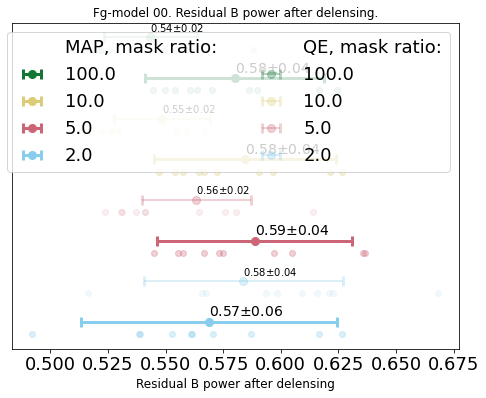

In [29]:
nlevels = [2.,5., 10., 100.]
nlevi_loc = [0,1,2,3]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))
for fgi, fg in enumerate(fgs):
    fig, ax = plt.subplots(figsize=(8,6))
    for nlevi, nlev in enumerate(nlevels_loc):
        for simidx in range(len(simids)):
            if simidx % 10 == 0:
                plt.errorbar(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=colors[nlevi], fmt='o', markersize=6, alpha=0.1)
                plt.errorbar(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=colors[nlevi], fmt='o', markersize=6, alpha=0.3)

        m_QE, s_QE = np.mean(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],:,1])
        plt.errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=colors[nlevi], fmt='o', markersize=8, alpha=0.3)
        plt.text(m_QE, 2*nlevi+1+0.15, r'%.2f$\pm$%.2f'%(m_QE, s_QE), fontsize=10)

        m_MAP, s_MAP = np.mean(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1])
        plt.errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=colors[nlevi], fmt='o', markersize=8)
        plt.text(m_MAP, 2*nlevi+0.15, r'%.2f$\pm$%.2f'%(m_MAP, s_MAP), fontsize=14)
    # for nlevi, nlev in enumerate(nlevels):

    plt.xlabel('Residual B power after delensing', fontsize=12)
    h, l = ax.get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2
    handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
    labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]
    leg = plt.legend(handles, labels, ncol=2)
    
    plt.title('Fg-model {}. Residual B power after delensing.'.format(fg), fontsize=12)
    # plt.xlim((0.21,0.435))
    # plt.ylim((0.5,4.5))
    # plt.yticklabels([])
    ax = plt.gca()
    ax.yaxis.set_visible(False)
    plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/residual_bpower_fg{}.pdf'.format(fg))

0.169$\pm$0.056


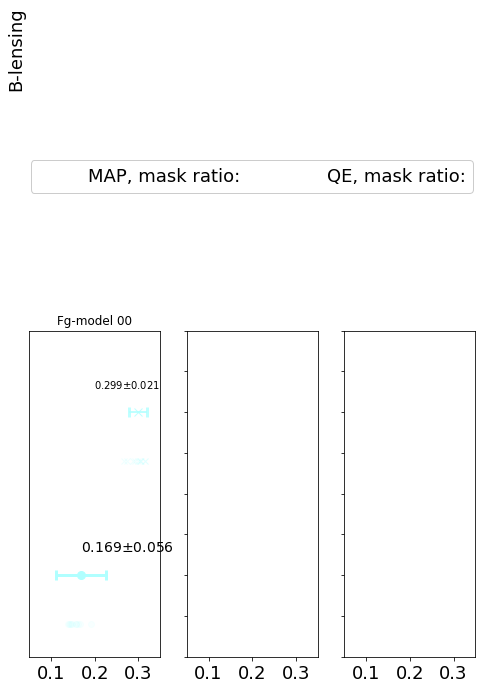

In [188]:
fig, ax = plt.subplots(1,3, figsize=(8,6), sharex=True, sharey= True)
# nlevels_loc = np.take(nlevels,np.array([0,3,5,7]))
nlevi_loc = [0]
nlevels_loc = np.take(nlevels,np.array(nlevi_loc))
xshift_QE_text = 0.1
xshift_MAP_text = 0.0
for fgi, fg in enumerate(fgs):
    for nlevi, nlev in enumerate(nlevels_loc):
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
            
        for simidx in range(len(simids)):
            if simidx%10 == 0:
                ax[fgi].errorbar(bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='x', markersize=6, alpha=0.2)
                ax[fgi].errorbar(bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='o', markersize=6, alpha=0.08)
        m_QE, s_QE = np.mean(bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_Llensc_QE_nm[fgi,nlevi_loc[nlevi],:,1])
        ax[fgi].errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=col, fmt='x', markersize=8, alpha=0.8)
        ax[fgi].text(m_QE-xshift_QE_text, 2*nlevi+1+0.15, r'%.3f$\pm$%.3f'%(m_QE, s_QE), fontsize=10)
        
        m_MAP, s_MAP = np.mean(bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_Llensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1])
        ax[fgi].errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=col, fmt='o', markersize=8)
        ax[fgi].text(m_MAP+xshift_MAP_text, 2*nlevi+0.15, r'%.3f$\pm$%.3f'%(m_MAP, s_MAP), fontsize=14)
        print(r'%.3f$\pm$%.3f'%(m_MAP, s_MAP))

    # ax[fgi].set_xlabel('Res. B-lens amplitude', fontsize=12)
    ax[fgi].set_title('Fg-model {}'.format(fg), fontsize=12)
    ax[fgi].yaxis.set_visible(False)
    ax[fgi].set_xlim((0.05,0.35))
    ax[fgi].set_ylim((-0.5,2*len(nlevels_loc)-0.5))

h, l = ax[1].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]
leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=[1.05, 1.55], framealpha=1)
    # plt.xlim((0.21,0.435))
    # plt.ylim((0.5,4.5))
    # plt.yticklabels([])
ax = plt.gca()
ax.text(-0.72,3, 'B-lensing', rotation=90)
# ax.yaxis.set_visible(False)
plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+survey+'/residual_lensing_amplitude_allfg.pdf'.format(fg), bbox_inches='tight')

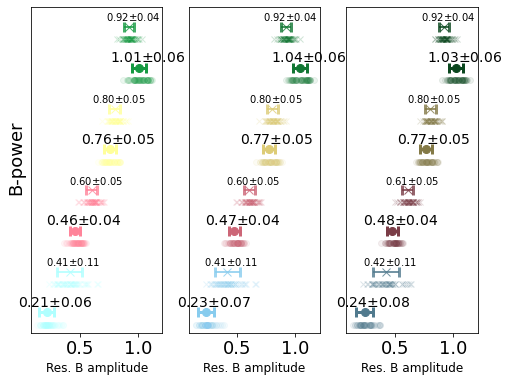

In [136]:
fig, ax = plt.subplots(1,3, figsize=(8,6), sharex=True, sharey= True)
nlevels_loc = np.take(nlevels,np.array([0,3,5,7]))
xshift_QE_text = +0.2
xshift_MAP_text = -0.25
for fgi, fg in enumerate(fgs):
    for nlevi, nlev in enumerate(nlevels_loc):
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)    
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)

        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)           
        for simidx in range(len(simids)):
            if simidx%10 == 0:
                ax[fgi].errorbar(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],simidx,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='x', markersize=6, alpha=0.2)
                ax[fgi].errorbar(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],simidx,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='o', markersize=6, alpha=0.08)

        m_QE, s_QE = np.mean(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],:,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_cslensc_QE_nm[fgi,nlevi_loc[nlevi],:,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],:,1])
        ax[fgi].errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=col, fmt='x', markersize=8, alpha=0.8)
        ax[fgi].text(m_QE-xshift_QE_text, 2*nlevi+1+0.15, r'%.2f$\pm$%.2f'%(m_QE, s_QE), fontsize=10)
        
        m_MAP, s_MAP = np.mean(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],:,1]), np.std(bcl_cslensc_MAP_nm[fgi,nlevi_loc[nlevi],:,1]/bcl_cs_nm[fgi,nlevi_loc[nlevi],:,1])
        ax[fgi].errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=col, fmt='o', markersize=8)
        ax[fgi].text(m_MAP+xshift_MAP_text, 2*nlevi+0.15, r'%.2f$\pm$%.2f'%(m_MAP, s_MAP), fontsize=14)

    ax[fgi].set_xlabel('Res. B amplitude', fontsize=12)
    # ax[fgi].set_title('Fg-model {}.'.format(fg), fontsize=12)
    ax[fgi].yaxis.set_visible(False)
    ax[fgi].set_ylim((-0.5,2*len(nlevels_loc)-0.5))
    
h, l = ax[0].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]

# leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=[0.2, 1.5], framealpha=1)
    # plt.xlim((0.21,0.435))
# plt.ylim((0.5,4.5))
# plt.yticklabels([])
ax = plt.gca()
ax.text(-2.85,3, 'B-power', rotation=90)
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/residual_ILCB-amplitude_allfg.pdf'.format(fg), bbox_inches='tight')

## Other

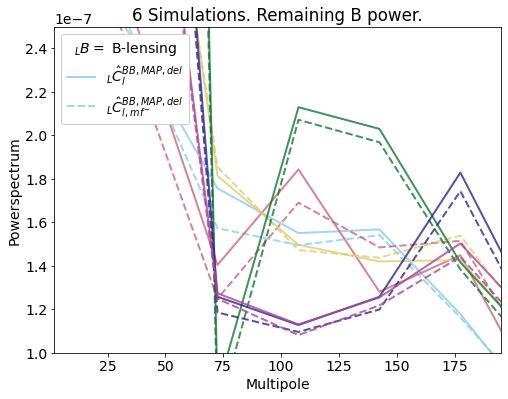

In [33]:
lmax_plot = 195
edges = edges
#np.arange(0,5,1)# simids#np.arange(0,1,1)
# fig, ax = plt.subplots(figsize=[8, 6])
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{L}B$'
label_cs = r'$_{C}B$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
label_MAP_mm = r'$_{{{}}}\hat{{C}}_{{l, mf^{{-}}}}^{{BB,MAP,del}}$'
QEMAP = 1

nlev = 4
def plot_content(a, baseBmap, sidx, fgi):
    if baseBmap == 'L':
        if QEMAP==0:
            a.plot(edges_center, bcl_Llensc_QE_nm[fgi,nlevi,sidx]*ct, label=label_QE.format(baseBmap), color=colors[3], alpha=0.8, lw=2)
        else:
            a.plot(edges_center, bcl_Llensc_MAP_nm[fgi,nlevi,sidx]*ct, label=label_MAP.format(baseBmap), color=colors[sidx], alpha=0.8, lw=2)
            ax.set_ylim((0.1e-6,0.25e-6))
    elif baseBmap == 'C':                 
        a.plot(edges_center, bcl_Llensc_QE_nm[fgi,nlevi,sidx]*ct, label=label_cs, alpha=1, color='lightblue')
            # a.plot(bcl_cslensc_QE_jm[sidx], label=label_QE.format(baseBmap), color=colors[3], alpha=0.3, lw=1)
        a.plot(edges_center, bcl_Llensc_MAP_nm[fgi,nlevi,sidx]*ct, label=label_MAP.format(baseBmap), color=colors[3], alpha=1, lw=1)
            # np.save('/global/homes/s/sebibel/notebooks/Pico/datasharing/ClBB_delensed_QE_%04d_ILCmask.npy'%(2*sidx+1), bcl_cslensc_QE_jm[sidx][2:200])

baseBmap = 'L' # C or L
fig, ax = plt.subplots(figsize=[8, 6]) 
simids_loc = simids
for fgi, fg in enumerate(fgs):
    for simidx in range(len(simids_loc)):
        plot_content(ax, baseBmap, simidx, fgi)
        label_QE, label_MAP = "", ""
        label_fQE, label_fMAP, label_csQE, label_csMAP, label_f, label_cs = None, None, None, None, None, None
        label_fQE_sm, label_fQE_cm, label_fMAP_sm, label_fMAP_cm =  None, None, None, None
        label_csMAP_sm, label_csMAP_cm, label_csQE_sm, label_csQE_cm =  None, None, None, None
        label_MAP_mm = ''
        # plot_content(axins, baseBmap, simidx)

        ax.set_title('%d Simulations.'%(len(simids)) + r' Remaining B power.')
        ax.set_xlim((2,lmax_plot))
        # 
        # ax.set_ylim((0.9,1.1))
        ax.set_xlabel('Multipole')
        ax.set_ylabel('Powerspectrum')

        if baseBmap == 'L': 
            ax.legend(title=r'$_{{{}}}B=$ B-lensing'.format(baseBmap), loc='upper left', framealpha=1.0)
        else: 
            ax.legend(title=r'$_{{{}}}B=$ ILC-map'.format(baseBmap), loc='upper left', framealpha=1.0)


    # ax.set_xscale('log')
    # ax.set_yscale('log')    
    

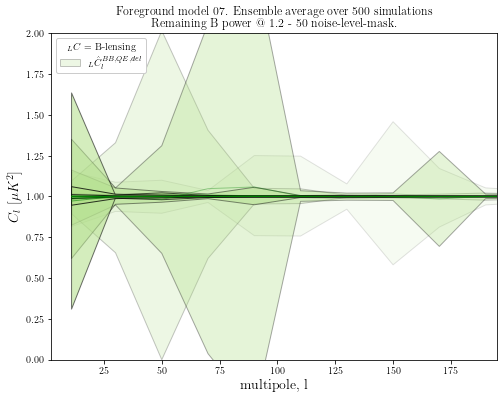

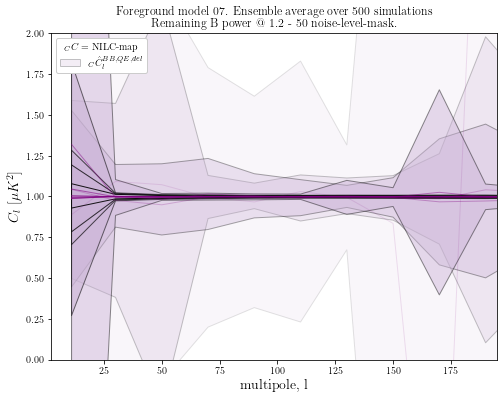

In [129]:
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1

def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi):
    # xshift = 1
    ms = 10
    alpha = (nlevi+1)/(len(nlevels)+1)
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2

        x, mean, std = get_ms(bcl_Llensc_QE_jm[0]/bcl_Llensc_QE_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=colors2[nlevi+len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='green', alpha=alpha, lw=1)
        
        # x, mean, std = get_ms(bcl_Llensc_MAP_jm[0]/bcl_Llensc_MAP_jm[1], binspace=binspace)
        # a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=colors2[nlevi+2*len(simids)], alpha=alpha, edgecolor='black')
        # a.plot(x, mean, color='red', alpha=alpha, lw=1)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 6, 9
        c3, c4 = 3, 1

        
        x, mean, std = get_ms(bcl_cslensc_QE_jm[0]/bcl_cslensc_QE_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=colors2[nlevi+4*len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        # x, mean, std = get_ms(bcl_cslensc_MAP_jm[0]/bcl_cslensc_MAP_jm[1], binspace=binspace)
        # a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=colors2[nlevi+5*len(simids)], alpha=alpha, edgecolor='black')
        # a.plot(x, mean, color='yellow', alpha=alpha, lw=1)


nlevels_loc = nlevels
for bB in ['L', 'C']:
    label_f = r'$_{{L}}C_l$'
    label_cs = r'$_{{C}}C_l$'
    label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
    label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
    fig, ax = plt.subplots(figsize=[8, 6])
    for nlevi, nlev in enumerate(nlevels):
    # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
        # nlevi=7
        baseBmap = bB
        label_f = None
        label_QE = ''
        label_MAP = ''
        label_cs = ''
        if nlevi == len(nlevels[-2:]) - 1:
            label_f = r'$_{{L}}C_l$'
            label_cs = r'$_{{C}}C_l$'
            label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
            label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        plot_content(ax, bcl_cs_nm[:,nlevi], bcl_L_nm[:,nlevi], bcl_Llensc_QE_nm[:,nlevi], bcl_cslensc_QE_nm[:,nlevi], bcl_Llensc_MAP_nm[:,nlevi], bcl_cslensc_MAP_nm[:,nlevi], baseBmap, nlevi)

    ax.set_xlim((2,lmax_plot))
    # ax.hlines(0, 0, 200, color='gray', ls='--')
    ax.set_xlabel(r'multipole, l', fontsize=14)
    ax.set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=14)
    if baseBmap == 'L': 
        ax.set_ylim((0,2))
        ax.legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper left', framealpha=1.0)
        ax.set_title('Foreground model {}. Ensemble average over {} simulations\n'.format(fg, len(simids)) + r'Remaining B power @ {} - {} noise-level-mask.'.format(nlevels_loc[0], nlevels_loc[-1]))
        x1, x2, y1, y2 = 2, 20, 0.0e-6, 2.5e-6
    else:
        ax.set_ylim((0,2))
        ax.legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper left', framealpha=1.0)
        ax.set_title('Foreground model {}. Ensemble average over {} simulations\n'.format(fg, len(simids)) + 'Remaining B power @ {} - {} noise-level-mask.'.format(nlevels_loc[0], nlevels_loc[-1]))
        # ax.set_title(r'Ensemble average - Remaining B power - Subtracting from ILC component separated input $B_{cs}$')
        x1, x2, y1, y2 = 2, 20, 0.0e-6, 3.8e-6
    # plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/{}ClBB_ens_avg.pdf'.format(bB))
    # sub region of the original image
    # axins.set_xlim(x1, x2)
    # axins.set_ylim(y1, y2)
    # axins.set_xticklabels([])
    # axins.set_yticklabels([])
    # ax.indicate_inset_zoom(axins, edgecolor="black")

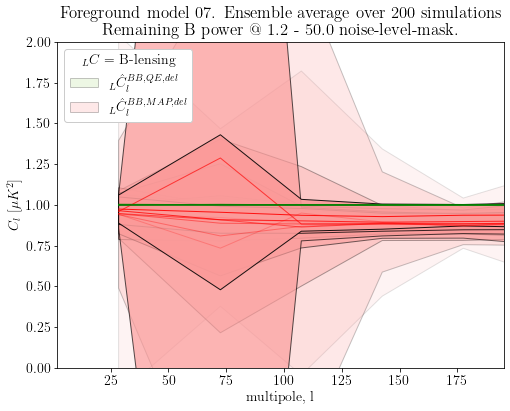

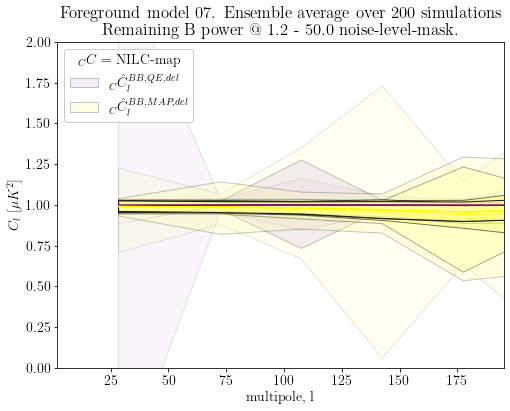

In [429]:
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(simids))) for nlevi in range(6*len(simids))])
binspace=1

def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi):
    # xshift = 1
    ms = 10
    alpha = (nlevi+1)/(len(nlevels)+1)
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2

        x, mean, std = get_ms(bcl_Llensc_QE_jm[0]/bcl_Llensc_QE_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=colors2[nlevi+len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='green', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_Llensc_MAP_jm[0]/bcl_Llensc_MAP_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=colors2[nlevi+2*len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='red', alpha=alpha, lw=1)



    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 6, 9
        c3, c4 = 3, 1

        x, mean, std = get_ms(bcl_cslensc_QE_jm[0]/bcl_cslensc_QE_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap), color=colors2[nlevi+4*len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm[0]/bcl_cslensc_MAP_jm[1], binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap), color=colors2[nlevi+5*len(simids)], alpha=alpha, edgecolor='black')
        a.plot(x, mean, color='yellow', alpha=alpha, lw=1)


nlevels_loc = nlevels
for bB in ['L', 'C']:
    label_f = r'$_{{L}}C_l$'
    label_cs = r'$_{{C}}C_l$'
    label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
    label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
    fig, ax = plt.subplots(figsize=[8, 6])
    for nlevi, nlev in enumerate(nlevels):
    # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
        # nlevi=7
        baseBmap = bB
        label_f = None
        label_QE = ''
        label_MAP = ''
        label_cs = ''
        if nlevi == len(nlevels[-2:]) - 1:
            label_f = r'$_{{L}}C_l$'
            label_cs = r'$_{{C}}C_l$'
            label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
            label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        plot_content(ax, bcl_cs_nm[:,nlevi], bcl_L_nm[:,nlevi], bcl_Llensc_QE_nm[:,nlevi], bcl_cslensc_QE_nm[:,nlevi], bcl_Llensc_MAP_nm[:,nlevi], bcl_cslensc_MAP_nm[:,nlevi], baseBmap, nlevi)

    ax.set_xlim((2,lmax_plot))
    # ax.hlines(0, 0, 200, color='gray', ls='--')
    ax.set_xlabel(r'multipole, l', fontsize=14)
    ax.set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=14)
    if baseBmap == 'L': 
        ax.set_ylim((0,2))
        ax.legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper left', framealpha=1.0)
        ax.set_title('Foreground model {}. Ensemble average over {} simulations\n'.format(fg, len(simids)) + r'Remaining B power @ {} - {} noise-level-mask.'.format(nlevels_loc[0], nlevels_loc[-1]))
        x1, x2, y1, y2 = 2, 20, 0.0e-6, 2.5e-6
    else:
        ax.set_ylim((0,2))
        ax.legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper left', framealpha=1.0)
        ax.set_title('Foreground model {}. Ensemble average over {} simulations\n'.format(fg, len(simids)) + 'Remaining B power @ {} - {} noise-level-mask.'.format(nlevels_loc[0], nlevels_loc[-1]))
        # ax.set_title(r'Ensemble average - Remaining B power - Subtracting from ILC component separated input $B_{cs}$')
        x1, x2, y1, y2 = 2, 20, 0.0e-6, 3.8e-6
    # plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/{}ClBB_ens_avg.pdf'.format(bB))
    # sub region of the original image
    # axins.set_xlim(x1, x2)
    # axins.set_ylim(y1, y2)
    # axins.set_xticklabels([])
    # axins.set_yticklabels([])
    # ax.indicate_inset_zoom(axins, edgecolor="black")